# Pairs Daily Analysis

Explore gold-layer co-movement data stored in the `pairs_daily` table. The notebook
uses Amazon Athena (via boto3) to pull metrics, then plots key analytics:

1. Histogram of the Geo-Temporal Jaccard (GTJ) score distribution.
2. Number of days individual pairs are observed together.
3. Inspection of GTJ values to surface a potential inflection point that separates
   routine overlap from likely coordinated movement.

In [10]:
import json
import os
import time

from pathlib import Path

import boto3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

# ---------------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------------
DATABASE = os.environ.get("PAIRS_DATABASE", "knap_ais")
TABLE = os.environ.get("PAIRS_TABLE", "pairs_daily")
ATHENA_OUTPUT = os.environ.get("ATHENA_STAGING_DIR") or "s3://knap-ais/athena-results/"
WORKGROUP = os.environ.get("ATHENA_WORKGROUP", "primary")
REGION = os.environ.get("AWS_REGION", "us-east-1")

print(f"Querying {DATABASE}.{TABLE} in {REGION}, workgroup={WORKGROUP}")

Querying knap_ais.pairs_daily in us-east-1, workgroup=primary


In [11]:
athena = boto3.client("athena", region_name=REGION)

def run_athena_query(sql: str, *, poll_seconds: float = 2.0) -> pd.DataFrame:
    """Execute an Athena query and return the results as a DataFrame."""
    response = athena.start_query_execution(
        QueryString=sql,
        QueryExecutionContext={"Database": DATABASE},
        WorkGroup=WORKGROUP,
        ResultConfiguration={"OutputLocation": ATHENA_OUTPUT},
    )
    execution_id = response["QueryExecutionId"]

    while True:
        status = athena.get_query_execution(QueryExecutionId=execution_id)
        state = status["QueryExecution"]["Status"]["State"]
        if state in {"SUCCEEDED", "FAILED", "CANCELLED"}:
            break
        time.sleep(poll_seconds)

    if state != "SUCCEEDED":
        reason = status["QueryExecution"]["Status"].get("StateChangeReason", "Unknown error")
        raise RuntimeError(f"Athena query failed: {state} -> {reason}")

    result = athena.get_query_results(QueryExecutionId=execution_id)

    rows = result["ResultSet"]["Rows"]
    headers = [col["VarCharValue"] for col in rows[0]["Data"]]
    values = []
    for row in rows[1:]:
        values.append([col.get("VarCharValue") for col in row["Data"]])

    # Handle pagination for large result sets.
    next_token = result.get("NextToken")
    while next_token:
        result = athena.get_query_results(QueryExecutionId=execution_id, NextToken=next_token)
        for row in result["ResultSet"]["Rows"]:
            values.append([col.get("VarCharValue") for col in row["Data"]])
        next_token = result.get("NextToken")

    frame = pd.DataFrame(values, columns=headers)
    return frame

In [12]:
SQL_SAMPLE = f"""
SELECT
  uid_a,
  uid_b,
  day_date,
  gtj,
  hT,
  gT
FROM {TABLE}
WHERE day_date BETWEEN DATE '2025-01-01' AND DATE '2025-01-31'
LIMIT 200000
"""

pairs = run_athena_query(SQL_SAMPLE)
pairs = pairs.astype({
    "day_date": "datetime64[ns]",
    "gtj": "float64",
    "hT": "int64",
    "gT": "int64",
})
pairs.head()

,uid_a,uid_b,day_date,gtj,hT,gT
0,367379290,368142910,2025-01-24,0.154762,6,2
1,311001607,367754810,2025-01-24,0.106335,2,2
2,367582850,368124040,2025-01-24,0.285366,7,2
3,338531000,366952790,2025-01-24,0.128788,4,2
4,367013240,367702490,2025-01-24,0.212121,4,2


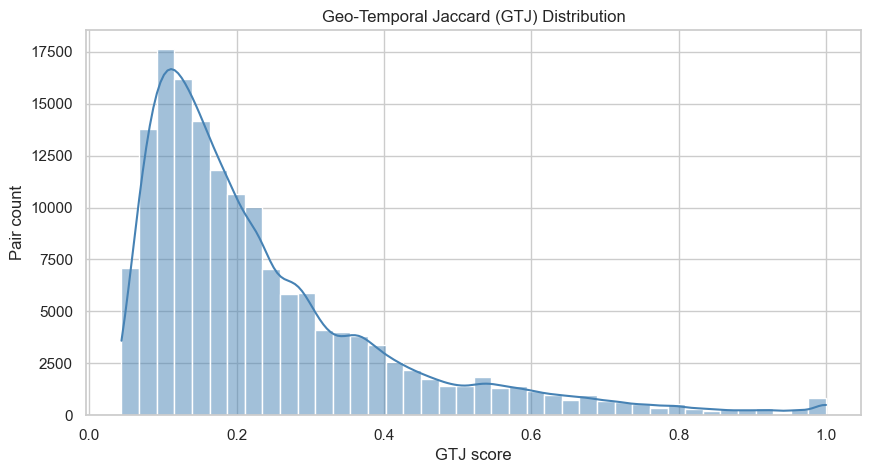

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(pairs["gtj"], bins=40, kde=True, color="steelblue")
plt.title("Geo-Temporal Jaccard (GTJ) Distribution")
plt.xlabel("GTJ score")
plt.ylabel("Pair count")
plt.show()


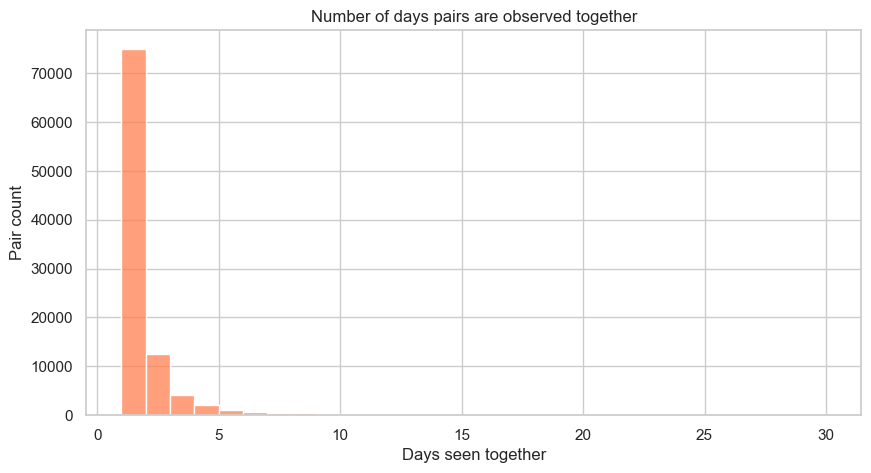

,uid_a,uid_b,days_seen,max_gtj
50191,367171010,367702510,30,0.888889
7494,316028554,316042365,30,0.888889
40565,367011510,367378120,30,0.750000
55071,367352630,368061910,29,0.685714
52265,367311510,367515330,29,0.888889


In [14]:
days_together = (
    pairs.groupby(["uid_a", "uid_b"], as_index=False)
    .agg(days_seen=("day_date", "nunique"), max_gtj=("gtj", "max"))
)

plt.figure(figsize=(10, 5))
sns.histplot(days_together["days_seen"], binwidth=1, color="coral")
plt.title("Number of days pairs are observed together")
plt.xlabel("Days seen together")
plt.ylabel("Pair count")
plt.show()

days_together.sort_values("days_seen", ascending=False).head()

,gtj
quantile,
0.50,0.183140
0.75,0.298701
0.90,0.481982
0.95,0.625000
0.99,0.895833


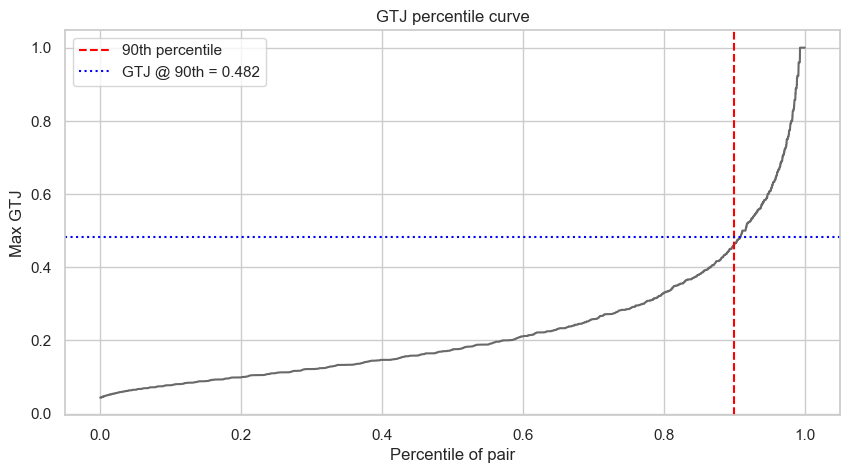

A potential inflection point is around the 90th percentile (GTJ ≈ 0.482), which often marks recurring co-movement beyond incidental overlap.


In [15]:
quantiles = pairs["gtj"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename_axis("quantile")
display(quantiles.to_frame("gtj"))

sorted_gtj = days_together.sort_values("max_gtj")
sorted_gtj["rank"] = range(1, len(sorted_gtj) + 1)
sorted_gtj["pct_rank"] = sorted_gtj["rank"] / len(sorted_gtj)

plt.figure(figsize=(10, 5))
plt.plot(sorted_gtj["pct_rank"], sorted_gtj["max_gtj"], color="dimgray")
plt.axvline(0.9, color="red", linestyle="--", label="90th percentile")
plt.axhline(quantiles.loc[0.9], color="blue", linestyle=":", label="GTJ @ 90th = {:.3f}".format(quantiles.loc[0.9]))
plt.xlabel("Percentile of pair")
plt.ylabel("Max GTJ")
plt.title("GTJ percentile curve")
plt.legend()
plt.show()

print(
    "A potential inflection point is around the 90th percentile (GTJ ≈ {:.3f}),".format(quantiles.loc[0.9]),
    "which often marks recurring co-movement beyond incidental overlap."
)

## Aggregate metrics for `pairs_total`

The snippet below mirrors the `sql/gold/create_pairs_total.sql` CTAS by summarising
the sampled data with pandas. Adjust the threshold as needed before writing the
results back to S3 or Athena.

In [16]:
GTJ_THRESHOLD = 0.4

pairs_total = (
    pairs.groupby(["uid_a", "uid_b"], as_index=False)
    .agg(
        total_days_observed=("day_date", "nunique"),
        days_with_gtj_above_threshold=("gtj", lambda s: (s >= GTJ_THRESHOLD).sum()),
        max_gtj=("gtj", "max"),
        min_gtj=("gtj", "min"),
        avg_gtj=("gtj", "mean"),
        median_gtj=("gtj", "median"),
        avg_hT=("hT", "mean"),
        median_hT=("hT", "median"),
        avg_gT=("gT", "mean"),
        median_gT=("gT", "median"),
    )
)

pairs_total.sort_values("days_with_gtj_above_threshold", ascending=False).head()

,uid_a,uid_b,total_days_observed,days_with_gtj_above_threshold,max_gtj,min_gtj,avg_gtj,median_gtj,avg_hT,median_hT,avg_gT,median_gT
7494,316028554,316042365,30,30,0.888889,0.585366,0.724548,0.705882,14.333333,14.0,2.000000,2.0
89116,368054820,368158890,29,29,0.774194,0.555556,0.645698,0.648649,10.379310,11.0,2.000000,2.0
56332,367369550,367515760,27,27,1.000000,0.555556,0.808937,0.827586,20.777778,21.0,3.148148,3.0
82343,367702510,367702530,29,27,0.923077,0.309524,0.648901,0.638889,16.862069,17.0,2.620690,3.0
77529,367633250,368310270,29,27,1.000000,0.366667,0.692159,0.722222,17.413793,18.0,2.655172,3.0


In [20]:
quantiles = pairs_total["avg_gT"].quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename_axis("quantile")
display(quantiles.to_frame("avg_gT"))

print('this is a strong sign we should have used a higher resolution h3')


,avg_gT
quantile,
0.50,2.0
0.75,2.0
0.90,2.5
0.95,3.0
0.99,4.0


this is a strong sign we should have used a higher resolution h3
